# Twisted Gaussian (banana) toy distribution

This distribution (described [here](http://pints.readthedocs.io/en/latest/toy/twisted_gaussian_logpdf.html)) has a curved "banana" shape. The problem can be more more or less difficult by changing the "bananicity" parameter `b`.

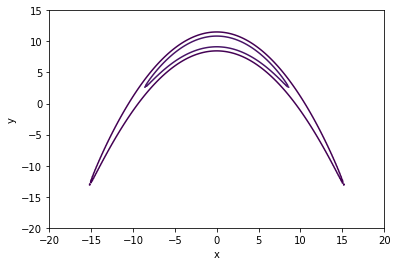

In [5]:
# Create log pdf
log_pdf = pints.toy.TwistedGaussianLogPDF(dimension=2, b=0.1)

# Contour plot of pdf
levels = np.linspace(-3, 12, 20)
x = np.linspace(-20, 20, 250)
y = np.linspace(-20, 15, 250)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]
plt.contour(X, Y, Z, levels = levels)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We now try to sample from the distribution with MCMC:

In [6]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform([-20, -20], [20, 15], size=(4, 2))
mcmc = pints.MCMCSampling(log_pdf, 4, x0, method=pints.AdaptiveCovarianceMCMC)

# Stop after 8000 iterations
mcmc.set_max_iterations(6000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Discard warm-up
chains = [chain[2000:] for chain in chains]

Running...
Done!


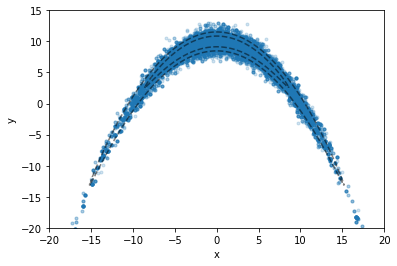

In [7]:
stacked = np.vstack(chains)
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-20, 20)
plt.ylim(-20, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()